In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset # Network Common Data Form
import sys
import xarray as xr
from datetime import date
from matplotlib import cm
from metpy.plots import ContourPlot, ImagePlot, MapPanel, PanelContainer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import copy
import os
import xesmf as xe

In [2]:
# Import Data in this cell
%run MapPlotImportData.ipynb

In [10]:
# ************************************************************************************************
# *************************** USER INPUTS ARE REQUIRED IN THIS CELL ******************************
# ************************************************************************************************


#### Select the date to be analyzed as a value representing the number of days since 2009-09-01 ####
dayOfTheSeason = 183 # For reference: 174 is February 22 and 122 is January 1

#### Select the number of days to be time averaged ####
numDayAvg = 2

#### Select which day hindcast should be used ####
#DayXXHcast = [5,10,15,20]  # Must be a list of integer(s) from >=1 and <=20

# Choose region of interest 
lats = -20
latn =  20
lonw = -180 # *** For longitudes west of the Prime Meridian, enter a negative number ***
lone = -90  

# ************************************************************************************************

In [11]:
## Select the data within the user defined region of interest

# Select the data within the region of interest
prectSel = [None] * len(dataPRECT)
vbotSel  = [None] * len(dataVBOT)
ubotSel  = [None] * len(dataUBOT)

# Iterate through each hindcast day to select the data in the region of interest
# The iteration starts at 1 to agree with the indexing convention of the hindcast days (starting with 1)
for ii in range(1,len(dataPRECT)): 
    # Subtract 1 from numDayAvg since a slice will include the end point
    # Add 360 to the longitude so that it agrees with the dataset which ranges from 0 to 360
    prectSel[ii] = dataPRECT[ii].sel(time=slice(dayOfTheSeason,dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw+360,lone+360))
    vbotSel[ ii] = dataVBOT[ ii].sel(time=slice(dayOfTheSeason,dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw+360,lone+360))
    ubotSel[ ii] = dataUBOT[ ii].sel(time=slice(dayOfTheSeason,dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw+360,lone+360))

# Note that the latitude slice is from north to south to match the wind obs convention. Also, a conversion is required for time
vbotObsSel = dataVBOTObs.sel(time=slice( (dayOfTheSeason+40055)*24+9, (dayOfTheSeason+40055+numDayAvg-1)*24+9), 
                             latitude=slice(latn,lats), longitude=slice(lonw+360,lone+360))
ubotObsSel = dataUBOTObs.sel(time=slice( (dayOfTheSeason+40055)*24+9, (dayOfTheSeason+40055+numDayAvg-1)*24+9), 
                             latitude=slice(latn,lats), longitude=slice(lonw+360,lone+360))

# Add 40055 to change the reference date of dayOfTheSeason from 2009-09-01 to 1900-01-01
prectObsSel = dataPRECTObs['pr'].sel(time=slice(dayOfTheSeason+40055, dayOfTheSeason+numDayAvg-1+40055), lat=slice(lats,latn), lon=slice(lonw,lone))

In [12]:
# Average the data for the length of the numDayAvg specificed 

# Initialize lists for hindcast data
prectPlot = [None] * len(prectSel)
vbotPlot  = [None] * len(vbotSel)
ubotPlot  = [None] * len(ubotSel)

# Perform time average for all hindcast days
for ii in range(1, len(prectSel)):
    prectPlot[ii] = prectSel[ii].mean(dim='time')
    vbotPlot[ ii] = vbotSel[ ii].mean(dim='time')
    ubotPlot[ ii] = ubotSel[ ii].mean(dim='time')

# Perform average for obs data
vbotObsPlot  = vbotObsSel.mean( dim='time')
ubotObsPlot  = ubotObsSel.mean( dim='time')
prectObsPlot = prectObsSel.mean(dim='time')

/opt/miniconda3/envs/prod/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


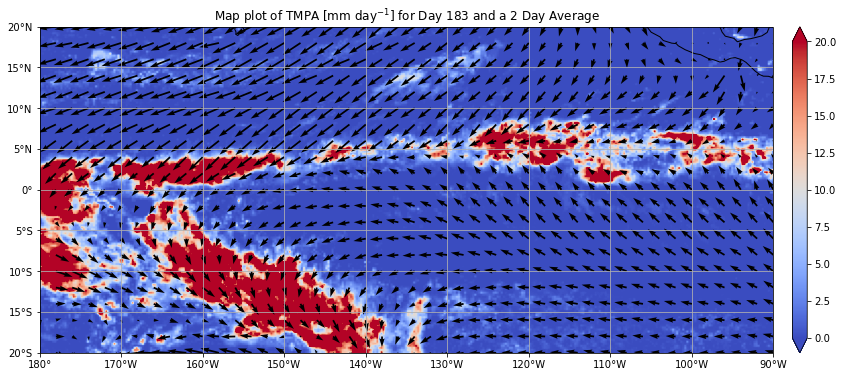

In [13]:
# Create a map plot of the observation data

# Create the figure and apply asthetic constraints
fig = plt.figure(figsize=(17, 6)) 

geo_axes = plt.axes(projection=ccrs.PlateCarree())
geo_axes.set_xticks(np.arange(lonw,lone+1,10), crs=ccrs.PlateCarree())
geo_axes.set_yticks(np.arange(lats,latn+1,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
geo_axes.xaxis.set_major_formatter(lon_formatter)
geo_axes.yaxis.set_major_formatter(lat_formatter)
geo_axes.coastlines(resolution='110m')
geo_axes.gridlines(xlocs=np.arange(lonw,lone+1,10), ylocs=np.arange(lats,latn+1,5))
image_extent = [lonw,lone,lats,latn]

# Set maximum of colorplot
Vmax = 20

# Plot precip contour plot
IM = geo_axes.imshow(prectObsPlot, extent=image_extent, cmap='coolwarm', vmax=Vmax, origin='lower')

# Set density of arrows with n. A greater integer reduces the density of arrows 
n = 8
# Plot wind vectors
geo_axes.quiver(ubotObsPlot['longitude'][::n],     ubotObsPlot['latitude'][::n], 
                ubotObsPlot['u10'][::n,::n], vbotObsPlot['v10'][::n,::n], transform=ccrs.PlateCarree())

# Set boundaries of plot
geo_axes.set_xlim([lonw,lone])
geo_axes.set_ylim([lats,latn])

plt.colorbar(IM, ax=geo_axes, orientation='vertical', pad=0.02, extend='both')
plt.title("Map plot of TMPA [mm day$^{-1}$] for Day "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average")

# Set the density of the pixels in the figure. This also affects the size of the saved figure
_dpi = 95


plt.show()

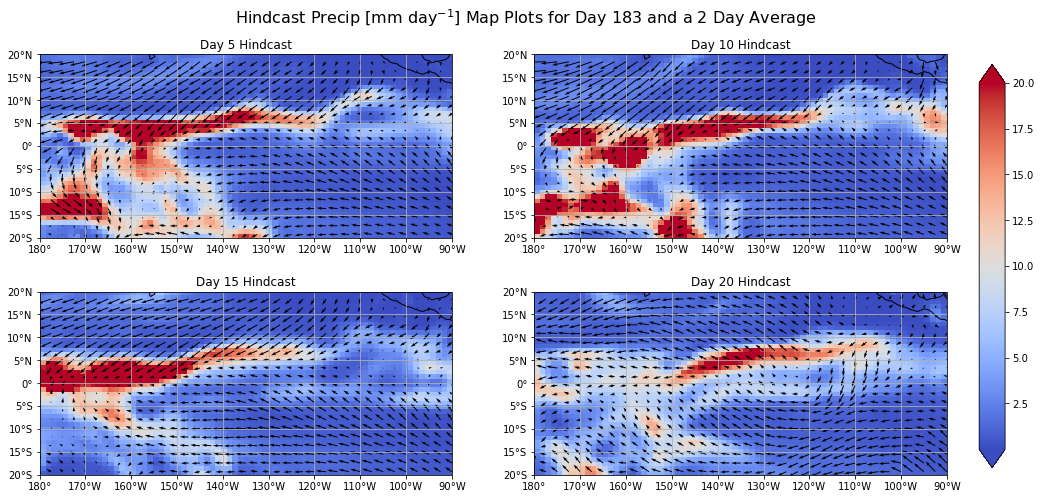

In [18]:
# Plot four subplots for each hindcast day

# Determine the maximum precip value for the colorbar
# mm/day
# Vmax = max([dataPlot[0]['prect'].max(), dataPlot[1]['prect'].max(), dataPlot[2]['prect'].max(), dataPlot[3]['prect'].max()])
# mm/hour
# Vmax = max([precip_avg5.max(),precip_avg10.max(),precip_avg15.max(),precip_avg20.max()])/24
Vmax = 20

# Set border of image
image_extent = [lonw,lone,lats,latn]

# Pre-generate the subplots with a PlateCarree projection
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Set density of arrows with n. A greater integer reduces the density of arrows
n = int(2)

hcastDay = [5,10,15,20]

# Iterate through the subplots
for ii, day in enumerate(hcastDay):
    # Plot precip in mm/day
#     im = ax.imshow(precip_avg[ii], extent=image_extent, cmap='coolwarm', vmax=Vmax)#, interpolation='bilinear')
    im = axes.flat[ii].imshow(prectPlot[day]['PRECT']*1000*86400, extent=image_extent, cmap='coolwarm', vmax=Vmax, origin='lower')
    # Plot precip in mm/hour
#     im = ax.imshow(precip_avg[ii]/24, extent=image_extent, cmap='coolwarm', vmin=0, vmax=Vmax) 

    axes.flat[ii].quiver(vbotPlot[day]['lon'][::n],   vbotPlot[day]['lat'][::n], 
                         ubotPlot[day]['u'][::n,::n], vbotPlot[day]['v'][::n,::n], transform=ccrs.PlateCarree())
    
    # Set boundaries of graphs
    axes.flat[ii].set_xlim([lonw,lone])
    axes.flat[ii].set_ylim([lats,latn])
    
    # Set asthetic constraints of the plot
    axes.flat[ii].set_xticks(np.arange(lonw,lone+1,10), crs=ccrs.PlateCarree())
    axes.flat[ii].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes.flat[ii].xaxis.set_major_formatter(lon_formatter)
    axes.flat[ii].yaxis.set_major_formatter(lat_formatter)
    axes.flat[ii].coastlines(resolution='110m')
    axes.flat[ii].gridlines(xlocs=np.arange(lonw,lone+1,10), ylocs=np.arange(lats,latn+1,5)) 
    axes.flat[ii].title.set_text('Day '+str((ii+1)*5)+' Hindcast')

    
# The following code creates a new axes for the colorbar
fig.subplots_adjust(right=0.825)
# Add base axis for color bar. Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')

fig.suptitle("Hindcast Precip [mm day$^{-1}$] Map Plots for Day "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average",
             size=16,y=0.95)

plt.savefig('/home/jlarson1/')
plt.show()

In [19]:
## Increase the spatial resolution of the hindcast dataset so that it equals the resolution of obs
## Then, find the absolute error between the hindcast precip and the obs precip
 
# Define a new dataset the has the spatial grid of the obs data
ds_out = xr.Dataset({'lat': (['lat'], prectObsPlot['lat']),
                     'lon': (['lon'], prectObsPlot['lon']) })

# Initialize an empty list to hold data for each hindcast day
errAbsAvg = [None] * len(prectPlot)

# Define the region of interest for the error analysis
latsErr = -5; latnErr = -1; lonwErr = -135; loneErr = -90

# Iterate through each hindcast day. Here "data" is the hindcast precipitation dataSet
for ii, data in enumerate(prectPlot):
    # Skip the zero index
    if ii==0: continue
        
    # Create a dataArray out of the dataset
    dr = data['PRECT']
    # Create a regridder function that will convert a dataArray with the resolution of the hindcasts to the resolution of the obs
    # Do this using a bilinear interpolation. Reusing the weights decreases computation time
    regridder = xe.Regridder(data['PRECT'], ds_out, 'bilinear', reuse_weights=True)
    # Regrid the precipitation dataArray
    dr_out = regridder(dr)
    # Calculate the difference between the hindcast precip and the obs precip
    errAbs = (dr_out*1000*86400) - prectObsPlot
    
    # Select the region that sees the highest amount of dITCZ bias
    errAbsSel = errAbs.sel(lon=slice(lonwErr,loneErr), lat=slice(latsErr,latnErr))
    # Take a spatial average over the aforementinoed region. Assign this to a list where each index is a hindcast day
    errAbsAvg[ii] = errAbsSel.mean()

Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc


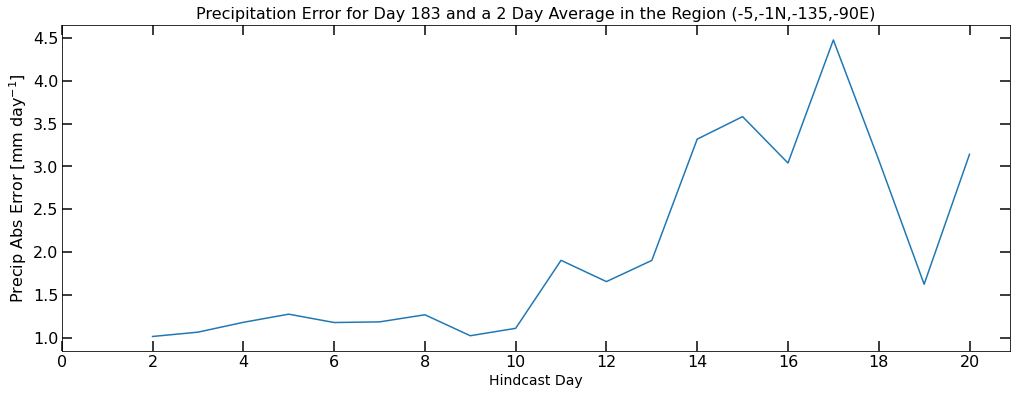

In [20]:
fig, ax = plt.subplots(figsize=(17,6))
plt.plot(errAbsAvg)
plt.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.xticks(np.arange(0,len(errAbsAvg),2))
plt.xlabel('Hindcast Day', fontsize=14)
plt.ylabel('Precip Abs Error [mm day$^{-1}$]', fontsize=16)
plt.title('Precipitation Error for Day '+str(dayOfTheSeason)+' and a '+str(numDayAvg)+' Day Average in the Region ('+
          str(latsErr)+','+str(latnErr)+'N,'+str(lonwErr)+','+str(loneErr)+'E)', fontsize=16, wrap=True)

plt.show()